In [1]:
from pandas import read_csv, read_feather, concat
import numpy as np

In [2]:
# for drawing barchart, so we don't have to retype the following everytime
def draw_barchart(df, title):
    fig = plt.figure(figsize=(20, 4))
    ax = fig.add_subplot(111)
    df.plot(kind='bar')
    ax.set_xlabel("(Year, Month)")
    plt.xticks(rotation=60) 
    plt.title(title)
    plt.show()

In [3]:
def distance(lat1, lng1, lat2, lng2):
    #return distance as meter if you want km distance, remove "* 1000"
    radius = 6371

    dLat = (lat2-lat1) * np.pi / 180
    dLng = (lng2-lng1) * np.pi / 180

    lat1 = lat1 * np.pi / 180
    lat2 = lat2 * np.pi / 180

    val = np.sin(dLat/2) * np.sin(dLat/2) + np.sin(dLng/2)\
    * np.sin(dLng/2) * np.cos(lat1) * np.cos(lat2)    
    ang = 2 * np.arctan2(np.sqrt(val), np.sqrt(1-val))
    return radius * ang

In [4]:
def add_airport_dist(dataset):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = distance(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = distance(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = distance(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = distance(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = distance(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = distance(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon) 
    
    dataset['jfk_dist'] = concat([pickup_jfk, dropoff_jfk], axis=1).min(axis=1)
    dataset['ewr_dist'] = concat([pickup_ewr, dropoff_ewr], axis=1).min(axis=1)
    dataset['lga_dist'] = concat([pickup_lga, dropoff_lga], axis=1).min(axis=1)
    
    return dataset

In [247]:
def transform(train_df):
    
    # Remove missing values
    train_df = train_df.dropna(how = 'any', axis = 'rows')

    # Remove absurd passenger_count
    train_df = train_df[(train_df['passenger_count'] >= 1) &
                    (train_df['passenger_count'] <= 6)]

    # Remove negative and extreme fare_amount values
    train_df = train_df[(train_df['fare_amount'] > 2.5) & (train_df['fare_amount'] <= 200)]
    print('Maximum fare_amount: %.1f' % train_df['fare_amount'].max())

    # Remove no displacements
    train_df = train_df[(train_df['pickup_latitude'] != train_df['dropoff_latitude'])]
    train_df = train_df[(train_df['pickup_longitude'] != train_df['dropoff_longitude'])]

    # Remove absurd displacements
    train_df = train_df[(train_df['pickup_longitude'] >= lng1min) & (train_df['pickup_longitude'] <= lng1max)]
    train_df = train_df[(train_df['dropoff_longitude'] >= lng2min) & (train_df['dropoff_longitude'] <= lng2max)]
    train_df = train_df[(train_df['pickup_latitude'] >= lat1min) & (train_df['pickup_latitude'] <= lat1max)]
    train_df = train_df[(train_df['dropoff_latitude'] >= lat2min) & (train_df['dropoff_latitude'] <= lat2max)]

    # Create new features - distance
    train_df['dist'] = distance(train_df['pickup_latitude'], train_df['pickup_longitude'],
                                train_df['dropoff_latitude'], train_df['dropoff_longitude'])
    train_df = train_df[train_df['dist'] <= 100]

    # Create new features - dayofweek,hour,month,year
    train_df['dayofweek'] = train_df['pickup_datetime'].dt.dayofweek.astype('uint8')
    train_df['hour'] = train_df['pickup_datetime'].dt.hour.astype('uint8')
    train_df['month'] = train_df['pickup_datetime'].dt.month.astype('uint8')
    train_df['year'] = train_df['pickup_datetime'].dt.year.astype('uint16')

    # Add minimum distances to the airports
    add_airport_dist(train_df)

    # Create dataframes for the two periods
    P1 = train_df[(train_df['pickup_datetime'] < '2012-09-01')]
    P2 = train_df.loc[(train_df['pickup_datetime'] >= '2012-09-01')]

    # Remove fixed values
    P1 = P1[(P1['fare_amount'] != 45) &
            (P1['fare_amount'] != 49.15) &
           (P1['fare_amount'] != 49.8) &
           (P1['fare_amount'] != 49.57) &
           (P1['fare_amount'] != 50) &
           (P1['fare_amount'] != 50.5)]
    P2 = P2[(P2['fare_amount'] != 57.33) &
           (P2['fare_amount'] != 52) &
           (P2['fare_amount'] != 56.8) &
           (P2['fare_amount'] != 57.54)]

    P1 = P1.drop(['pickup_datetime'], axis=1)
    print(P1.shape)
    P2 = P2.drop(['pickup_datetime'], axis=1)
    print(P2.shape)
    
    # Save memory
    print(train_df.shape)
    print('Maximum ride distance: %.1f' % train_df['dist'].max())
    del train_df
    return P1,P2

In [248]:
# No missing values
test_df = read_csv('test.csv', parse_dates=["pickup_datetime"],
                  infer_datetime_format=True)

lng1min = test_df.pickup_longitude.min()
lng2min = test_df.dropoff_longitude.min()
lat1min = test_df.pickup_latitude.min()
lat2min = test_df.dropoff_latitude.min()
#
lng1max = test_df.pickup_longitude.max()
lng2max = test_df.dropoff_longitude.max()
lat1max = test_df.pickup_latitude.max()
lat2max = test_df.dropoff_latitude.max()

## Find outliers in P1

In [249]:
%%time
#train_df = read_feather('tmp/train100K.feather')
train_df = read_csv('train1.csv', parse_dates=['pickup_datetime'], infer_datetime_format=True)
train_df = train_df.drop('key', axis=1)
print(train_df.shape)
P1, P2 = transform(train_df)

(2000000, 7)
Maximum fare_amount: 200.0
(1080880, 14)
(811060, 14)
(1922963, 15)
Maximum ride distance: 99.9
CPU times: user 28.6 s, sys: 3.03 s, total: 31.7 s
Wall time: 21.9 s


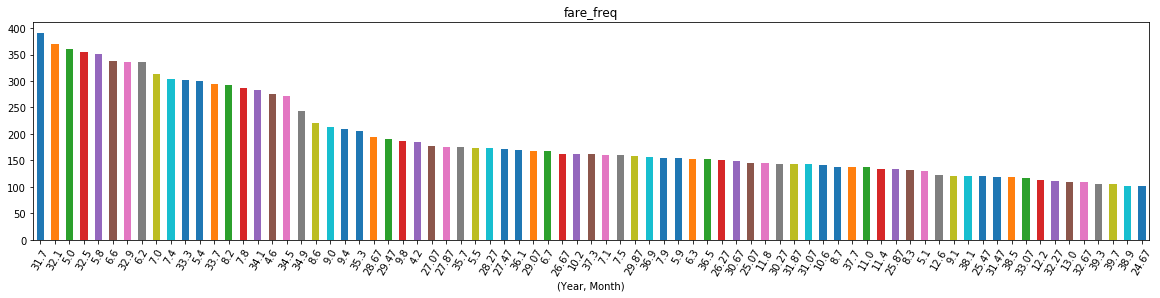

In [166]:
#train_df.groupby('fare_amount').count()
fare_freq = P1['fare_amount'].value_counts()
#fare_freq = fare_freq[(fare_freq[:,]>100) & (fare_freq[:,]<1000)]
fare_freq = fare_freq[(fare_freq[:,]>100) & (fare_freq[:,]<400)]
draw_barchart(fare_freq, 'fare_freq')

In [122]:
#fare_freq[fare_freq[:,]<2]
#fare_freq[:45]
#print(fare_low.shape)

In [ ]:
P1.head()

In [ ]:
P1.describe()

In [168]:
from sklearn.model_selection import train_test_split

X = P1.iloc[:,1:].values
#y = np.log10(P1.iloc[:,0].values)
y = P1.iloc[:,0].values

seed = 101

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.4, random_state=seed)

In [173]:
%%time
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

#model = RandomForestRegressor(random_state=seed, n_estimators=15,
#                              max_depth = 15, n_jobs = -1)
model = ExtraTreesRegressor(random_state=seed, n_estimators=15,
                              max_depth = 15, n_jobs = -1)

#scores = cross_val_score(model, X_train, y_train, cv=3, scoring=make_scorer(mean_squared_error))
#print('RMSE CV: %.3f +/- %.3f' % (np.sqrt(np.mean(scores)), np.sqrt(np.std(scores))))

ransac1 = RANSACRegressor(model,
                         max_trials=100,
                         min_samples=50,
                         loss='absolute_loss',
                         residual_threshold=200,
                         random_state=0)

#scores = cross_val_score(ransac1, X_train, y_train, cv=3, scoring=make_scorer(mean_squared_error))
#print('RMSE CV with RANSAC: %.3f +/- %.3f' % (np.sqrt(np.mean(scores)), np.sqrt(np.std(scores))))

ransac1.fit(X_train, y_train)
y_pred = ransac1.predict(X_train)
print('RMSE before gridsearch train set: %.4f' % np.sqrt(mean_squared_error(y_pred,y_train)))
y_pred_test = ransac1.predict(X_test)
print('RMSE before gridsearch test set: %.4f' % np.sqrt(mean_squared_error(y_pred_test,y_test)))

RMSE before gridsearch train set: 2.3988
RMSE before gridsearch test set: 2.9490
CPU times: user 42.1 s, sys: 2.19 s, total: 44.3 s
Wall time: 6.21 s


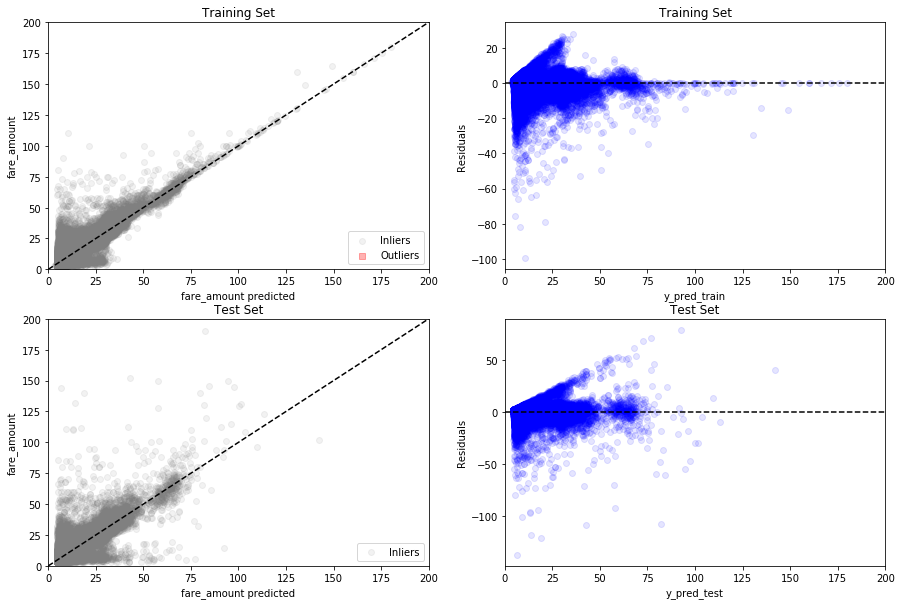

In [174]:
import matplotlib.pyplot as plt
%matplotlib inline

inlier_mask = ransac1.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

plt.figure(figsize=(15, 10))
ax1 = plt.subplot(221)
ax1.scatter(y_pred[inlier_mask], y_train[inlier_mask],
            c='gray', alpha=0.1,
            marker='o', label='Inliers')
ax1.scatter(y_pred[outlier_mask], y_train[outlier_mask],
            c='red', alpha=0.3,
            marker='s', label='Outliers')
ax1.set_xlim(0,200)
ax1.set_ylim(0,200)
ax1.plot((0,200),(0,200), c = 'black', linestyle = 'dashed')
ax1.set_title('Training Set')
ax1.set_xlabel('fare_amount predicted')
ax1.set_ylabel('fare_amount')
ax1.legend(loc='lower right')

ax2 = plt.subplot(222)
ax2.scatter(y_pred, y_pred - y_train, c = 'blue', alpha = 0.1)
ax2.set_xlim(0,200)
ax2.plot((0,200),(0,0), c = 'black', linestyle = 'dashed')
ax2.set_title('Training Set')
ax2.set_xlabel('y_pred_train')
ax2.set_ylabel('Residuals')

ax3 = plt.subplot(223)
ax3.scatter(y_pred_test, y_test,
            c='gray', alpha=0.1,
            marker='o', label='Inliers')
ax3.set_xlim(0,200)
ax3.set_ylim(0,200)
ax3.plot((0,200),(0,200), c = 'black', linestyle = 'dashed')
ax3.set_title('Test Set')
ax3.set_xlabel('fare_amount predicted')
ax3.set_ylabel('fare_amount')
ax3.legend(loc='lower right')

ax4 = plt.subplot(224)
ax4.scatter(y_pred_test, y_pred_test - y_test, c = 'blue', alpha = 0.1)
ax4.set_xlim(0,200)
ax4.plot((0,200),(0,0), c = 'black', linestyle = 'dashed')
ax4.set_title('Test Set')
ax4.set_xlabel('y_pred_test')
ax4.set_ylabel('Residuals')


#plt.subplots_adjust(wspace=0.4, top=0.5)
plt.show()

In [175]:
print('Number of outliers: %.i'% y_pred[outlier_mask].shape)

Number of outliers: 0


# Train Model P1

In [250]:
from sklearn.model_selection import train_test_split

X = P1.iloc[:,1:].values
y = np.log10(P1.iloc[:,0].values)
#y = P1.iloc[:,0].values

seed = 101

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.3, random_state=seed)

In [251]:
%%time
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error

modelP1=xgb.XGBRegressor(colsample_bytree=0.8,
                         gamma=0,
                         learning_rate=0.05,
                         max_depth=20,
                         min_child_weight=1,
                         n_estimators=300,
                         objective= "reg:linear",
                         nthread=-1)

modelP1.fit(X_train,y_train)
y_pred = modelP1.predict(X_test)
print('RMSE before gridsearch: %.4f' % np.sqrt(mean_squared_error(y_pred,y_test)))

RMSE before gridsearch: 0.0870
CPU times: user 43min 13s, sys: 2min 5s, total: 45min 18s
Wall time: 10min 19s


## Find outliers in P2

In [252]:
%%time
train_df = read_csv('train1.csv', parse_dates=['pickup_datetime'], infer_datetime_format=True)
train_df = train_df.drop('key', axis=1)
print(train_df.shape)
P1, P2 = transform(train_df)

(2000000, 7)
Maximum fare_amount: 200.0
(1080880, 14)
(811060, 14)
(1922963, 15)
Maximum ride distance: 99.9
CPU times: user 29.5 s, sys: 4.03 s, total: 33.5 s
Wall time: 22.9 s


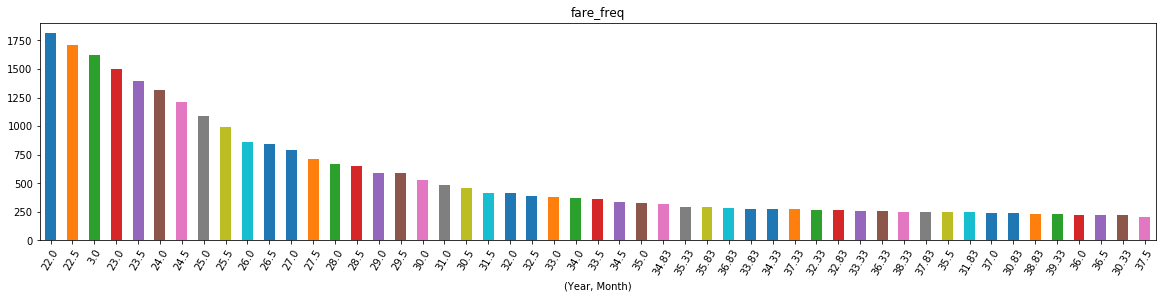

In [237]:
#train_df.groupby('fare_amount').count()
fare_freq = P2['fare_amount'].value_counts()
fare_freq = fare_freq[(fare_freq[:,]>200) & (fare_freq[:,]<2000)]
draw_barchart(fare_freq, 'fare_freq')

In [ ]:
P2.head()

In [ ]:
P2.describe()

In [238]:
from sklearn.model_selection import train_test_split

X = P2.iloc[:,1:].values
#y = np.log10(P1.iloc[:,0].values)
y = P2.iloc[:,0].values

seed = 101

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2, random_state=seed)

In [239]:
%%time
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import ExtraTreesRegressor
#from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#model = RandomForestRegressor(random_state=seed, n_estimators=15,
#                              max_depth = 15, n_jobs = -1)
model = ExtraTreesRegressor(random_state=seed, n_estimators=15,
                              max_depth = 15, n_jobs = -1)

ransac2 = RANSACRegressor(model,
                         max_trials=100,
                         min_samples=50,
                         loss='absolute_loss',
                         residual_threshold=200,
                         random_state=0)
ransac2.fit(X_train, y_train)

y_pred = ransac2.predict(X_train)
print('RMSE before gridsearch train set: %.4f' % np.sqrt(mean_squared_error(y_pred,y_train)))
y_pred_test = ransac2.predict(X_test)
print('RMSE before gridsearch test set: %.4f' % np.sqrt(mean_squared_error(y_pred_test,y_test)))

RMSE before gridsearch train set: 2.8276
RMSE before gridsearch test set: 3.3223
CPU times: user 41.1 s, sys: 2.65 s, total: 43.8 s
Wall time: 6.15 s


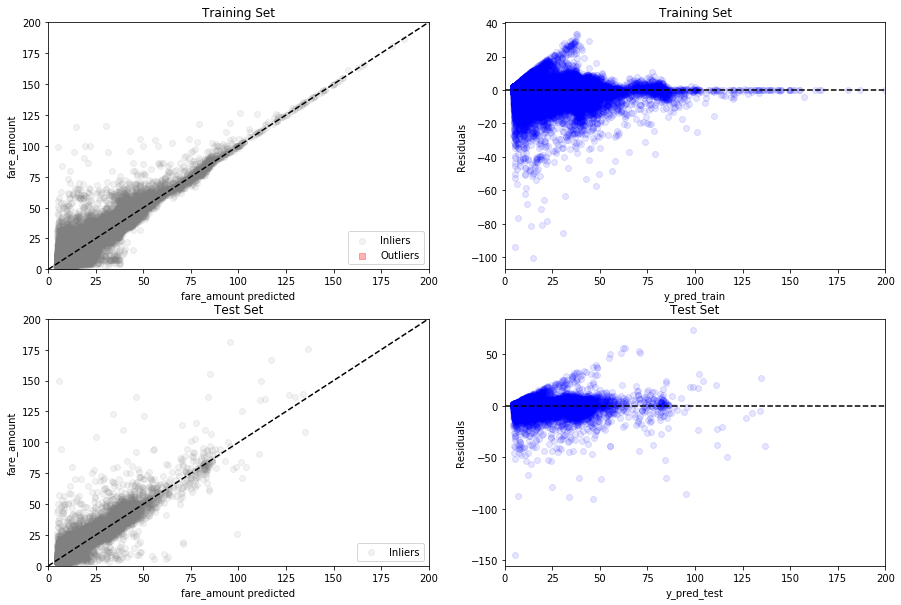

In [242]:
import matplotlib.pyplot as plt
%matplotlib inline

inlier_mask = ransac2.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

plt.figure(figsize=(15, 10))
ax1 = plt.subplot(221)
ax1.scatter(y_pred[inlier_mask], y_train[inlier_mask],
            c='gray', alpha=0.1,
            marker='o', label='Inliers')
ax1.scatter(y_pred[outlier_mask], y_train[outlier_mask],
            c='red', alpha=0.3,
            marker='s', label='Outliers')
ax1.set_xlim(0,200)
ax1.set_ylim(0,200)
ax1.plot((0,200),(0,200), c = 'black', linestyle = 'dashed')
ax1.set_title('Training Set')
ax1.set_xlabel('fare_amount predicted')
ax1.set_ylabel('fare_amount')
ax1.legend(loc='lower right')

ax2 = plt.subplot(222)
ax2.scatter(y_pred, y_pred - y_train, c = 'blue', alpha = 0.1)
ax2.set_xlim(0,200)
ax2.plot((0,200),(0,0), c = 'black', linestyle = 'dashed')
ax2.set_title('Training Set')
ax2.set_xlabel('y_pred_train')
ax2.set_ylabel('Residuals')

ax3 = plt.subplot(223)
ax3.scatter(y_pred_test, y_test,
            c='gray', alpha=0.1,
            marker='o', label='Inliers')
ax3.set_xlim(0,200)
ax3.set_ylim(0,200)
ax3.plot((0,200),(0,200), c = 'black', linestyle = 'dashed')
ax3.set_title('Test Set')
ax3.set_xlabel('fare_amount predicted')
ax3.set_ylabel('fare_amount')
ax3.legend(loc='lower right')

ax4 = plt.subplot(224)
ax4.scatter(y_pred_test, y_pred_test - y_test, c = 'blue', alpha = 0.1)
ax4.set_xlim(0,200)
ax4.plot((0,200),(0,0), c = 'black', linestyle = 'dashed')
ax4.set_title('Test Set')
ax4.set_xlabel('y_pred_test')
ax4.set_ylabel('Residuals')


#plt.subplots_adjust(wspace=0.4, top=0.5)
plt.show()

In [241]:
print('Number of outliers: %.i'% y_pred[outlier_mask].shape)

Number of outliers: 0


# Train Model P2

In [253]:
from sklearn.model_selection import train_test_split

X = P2.iloc[:,1:].values
y = np.log10(P2.iloc[:,0].values)
#y = P2.iloc[:,0].values

seed = 101

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.3, random_state=seed)

In [259]:
%%time
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error

modelP2=xgb.XGBRegressor(colsample_bytree=0.8,
                         gamma=0,
                         learning_rate=0.05,
                         max_depth=8,
                         min_child_weight=1,
                         n_estimators=100,
                         objective= "reg:linear",
                         nthread=-1)

modelP2.fit(X_train,y_train)
y_pred = modelP2.predict(X_test)
print('RMSE before gridsearch: %.4f' % np.sqrt(mean_squared_error(y_pred,y_test)))

RMSE before gridsearch: 0.0912
CPU times: user 3min 17s, sys: 10.9 s, total: 3min 28s
Wall time: 49 s


## Make predictions on the test set

In [255]:
# No missing values
test_df = read_csv('test.csv', parse_dates=["pickup_datetime"],
                  infer_datetime_format=True)

test_df['dist'] = distance(test_df['pickup_latitude'], test_df['pickup_longitude'],
                           test_df['dropoff_latitude'], test_df['dropoff_longitude'])

print('Minimum ride distance: %.1f' % test_df['dist'].min())
print('Maximum ride distance: %.1f' % test_df['dist'].max())

test_df['dayofweek'] = test_df['pickup_datetime'].dt.dayofweek #.astype('uint8')
test_df['hour'] = test_df['pickup_datetime'].dt.hour #.astype('uint8')
test_df['month'] = test_df['pickup_datetime'].dt.month #.astype('uint8')
test_df['year'] = test_df['pickup_datetime'].dt.year #.astype('uint8')

# Add minimum distances to the airports
add_airport_dist(test_df)

#test_df = test_df.drop(['passenger_count'], axis=1)
test_df.head()

Minimum ride distance: 0.0
Maximum ride distance: 100.0


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist,dayofweek,hour,month,year,jfk_dist,ewr_dist,lga_dist
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,2.323260,1,13,1,2015,20.630787,16.776178,8.611599
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,2.425353,1,13,1,2015,19.647702,15.217920,11.446400
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,0.618628,5,11,10,2011,20.652459,16.988793,9.656367
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,1.961033,5,21,12,2012,21.747868,16.391035,9.200895
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,5.387301,5,21,12,2012,21.167442,16.235246,7.989082


In [256]:
X_testF = test_df.iloc[:,2:].values
y_predFP1 = 10**(modelP1.predict(X_testF).round(4))
y_predFP2 = 10**(modelP2.predict(X_testF).round(4))
#y_predFP1 = ransac1.predict(X_testF).round(4)
#y_predFP2 = ransac2.predict(X_testF).round(4)

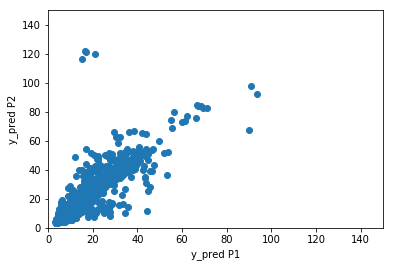

In [257]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(y_predFP1, y_predFP2)
plt.xlabel('y_pred P1')
plt.ylabel('y_pred P2')
plt.xlim(0,150)
plt.ylim(0,150)
plt.show()

In [258]:
from pandas import DataFrame

submission = DataFrame({'key': test_df.key, 'fare_amountP1': y_predFP1,
                        'fare_amountP2': y_predFP2},
                       columns = ['key', 'fare_amountP1', 'fare_amountP2'])

submission['fare_amount'] = np.where(test_df['pickup_datetime'] < '2012-09-01',
                                     submission['fare_amountP1'],
                                     submission['fare_amountP2'])

submission = submission.drop(['fare_amountP1','fare_amountP2'], axis=1)
submission.to_csv('submission.csv', index = False)
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.970112
1,2015-01-27 13:08:24.0000003,10.377675
2,2011-10-08 11:53:44.0000002,4.041104
3,2012-12-01 21:12:12.0000002,9.397233
4,2012-12-01 21:12:12.0000003,14.969248
